# Bitcoin Price. Prediction by ARIMA

In [63]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [108]:
df=pd.read_csv('/kaggle/input/bit-coin-data-2018-2021-cleaned/Bitcoin_Data_2018_to_2021.csv')

In [109]:
# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

# Convert the datetime object to a Unix timestamp
df['timestamp'] = df['date'].astype(int) // 10**9


In [110]:
df.head()

,date,Open,Close,High,Low,Volume,timestamp
0,2018-01-07,18343.662493,17039.873914,18343.662493,14093.606831,16385.178543,1515283200
1,2018-01-08,17039.873914,15900.365022,18343.662493,15321.932852,16643.286856,1515369600
2,2018-01-09,15900.365022,15604.723408,18343.662493,15583.885538,16683.685507,1515456000
3,2018-01-10,15604.723408,15509.270127,18343.662493,15509.270127,16673.026163,1515542400
4,2018-01-11,15509.270127,14050.569606,18343.662493,14050.569606,16397.912507,1515628800


In [111]:
# df=df.drop('date',axis=1)


In [112]:
df.head()

,date,Open,Close,High,Low,Volume,timestamp
0,2018-01-07,18343.662493,17039.873914,18343.662493,14093.606831,16385.178543,1515283200
1,2018-01-08,17039.873914,15900.365022,18343.662493,15321.932852,16643.286856,1515369600
2,2018-01-09,15900.365022,15604.723408,18343.662493,15583.885538,16683.685507,1515456000
3,2018-01-10,15604.723408,15509.270127,18343.662493,15509.270127,16673.026163,1515542400
4,2018-01-11,15509.270127,14050.569606,18343.662493,14050.569606,16397.912507,1515628800


## Data Exploration

In [113]:
# Load data
#df = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()



,date,Open,Close,High,Low,Volume,timestamp
0,2018-01-07,18343.662493,17039.873914,18343.662493,14093.606831,16385.178543,1515283200
1,2018-01-08,17039.873914,15900.365022,18343.662493,15321.932852,16643.286856,1515369600
2,2018-01-09,15900.365022,15604.723408,18343.662493,15583.885538,16683.685507,1515456000
3,2018-01-10,15604.723408,15509.270127,18343.662493,15509.270127,16673.026163,1515542400
4,2018-01-11,15509.270127,14050.569606,18343.662493,14050.569606,16397.912507,1515628800


In [114]:
df.dtypes

date         datetime64[ns]
Open                float64
Close               float64
High                float64
Low                 float64
Volume              float64
timestamp             int64
dtype: object

In [115]:
df=pd.DataFrame(df)

In [116]:
df.columns


Index(['date', 'Open', 'Close', 'High', 'Low', 'Volume', 'timestamp'], dtype='object')

In [118]:
# Unix-time to 
df.timestamp = pd.to_datetime(df.timestamp, unit='s')

# Resampling to daily frequency
df.index = df.timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

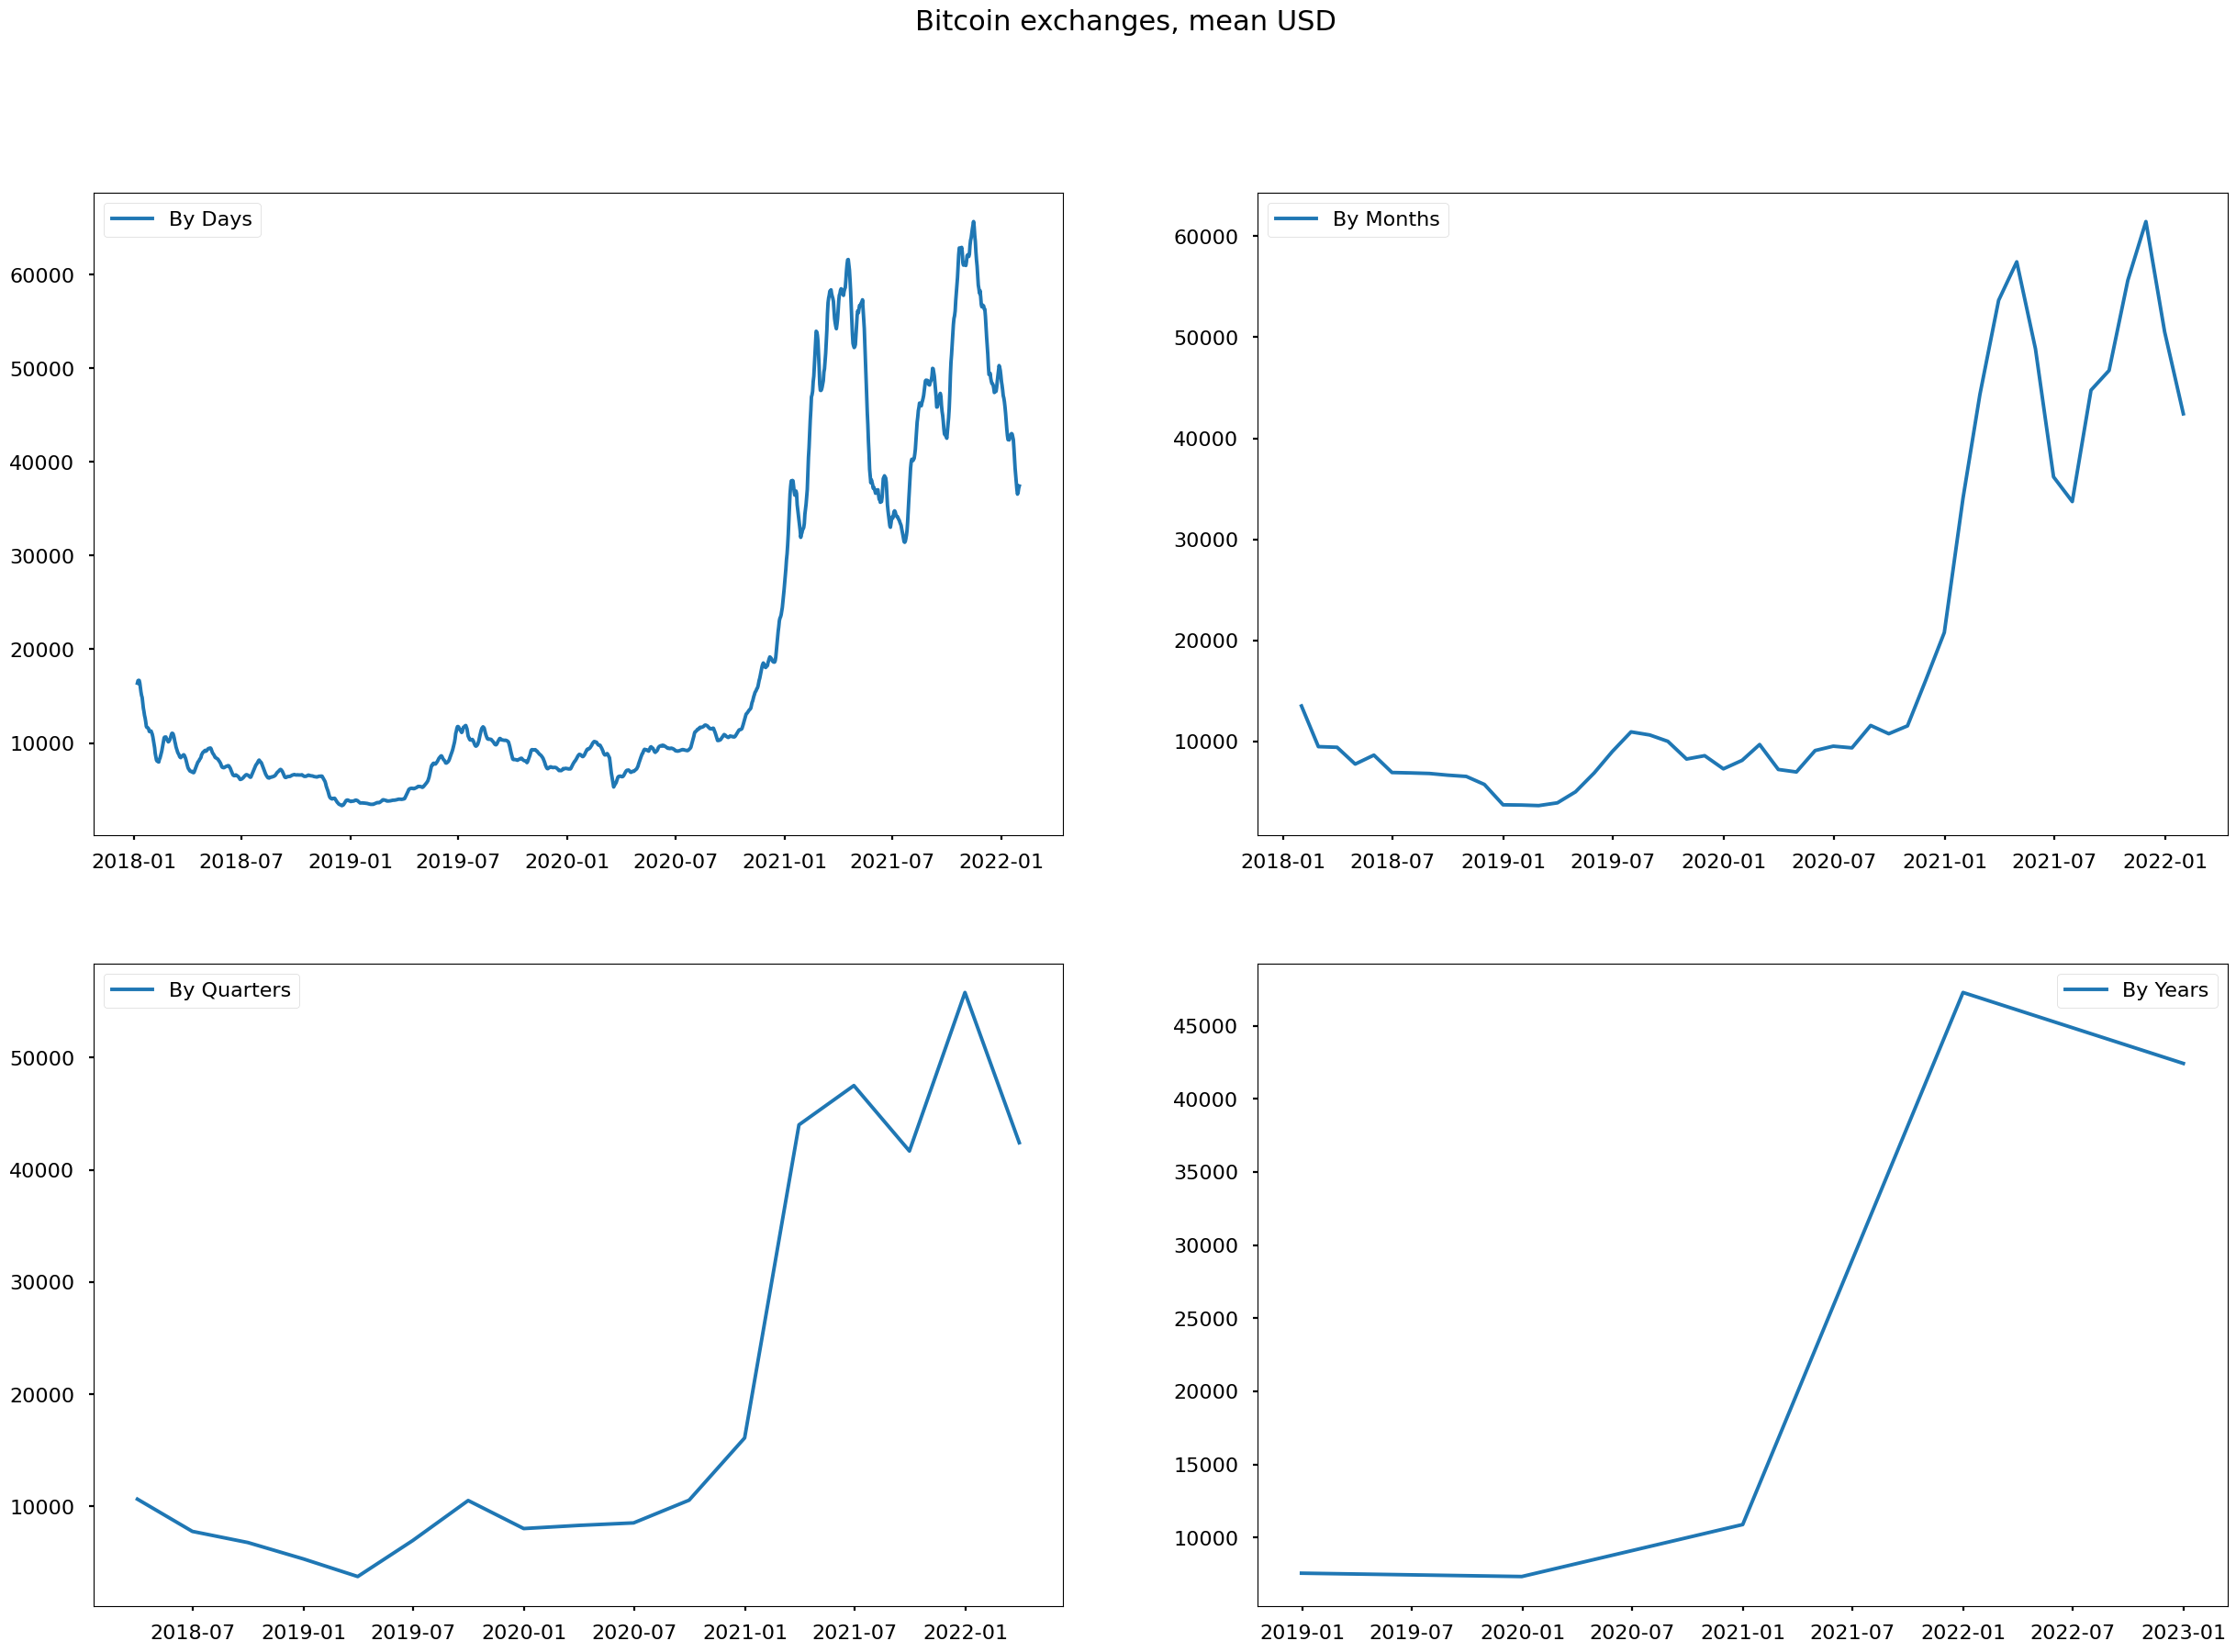

In [156]:
# PLOTS
fig = plt.figure(figsize=[30,20])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Volume, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Volume, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Volume, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Volume, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.986021


<Figure size 1500x700 with 0 Axes>

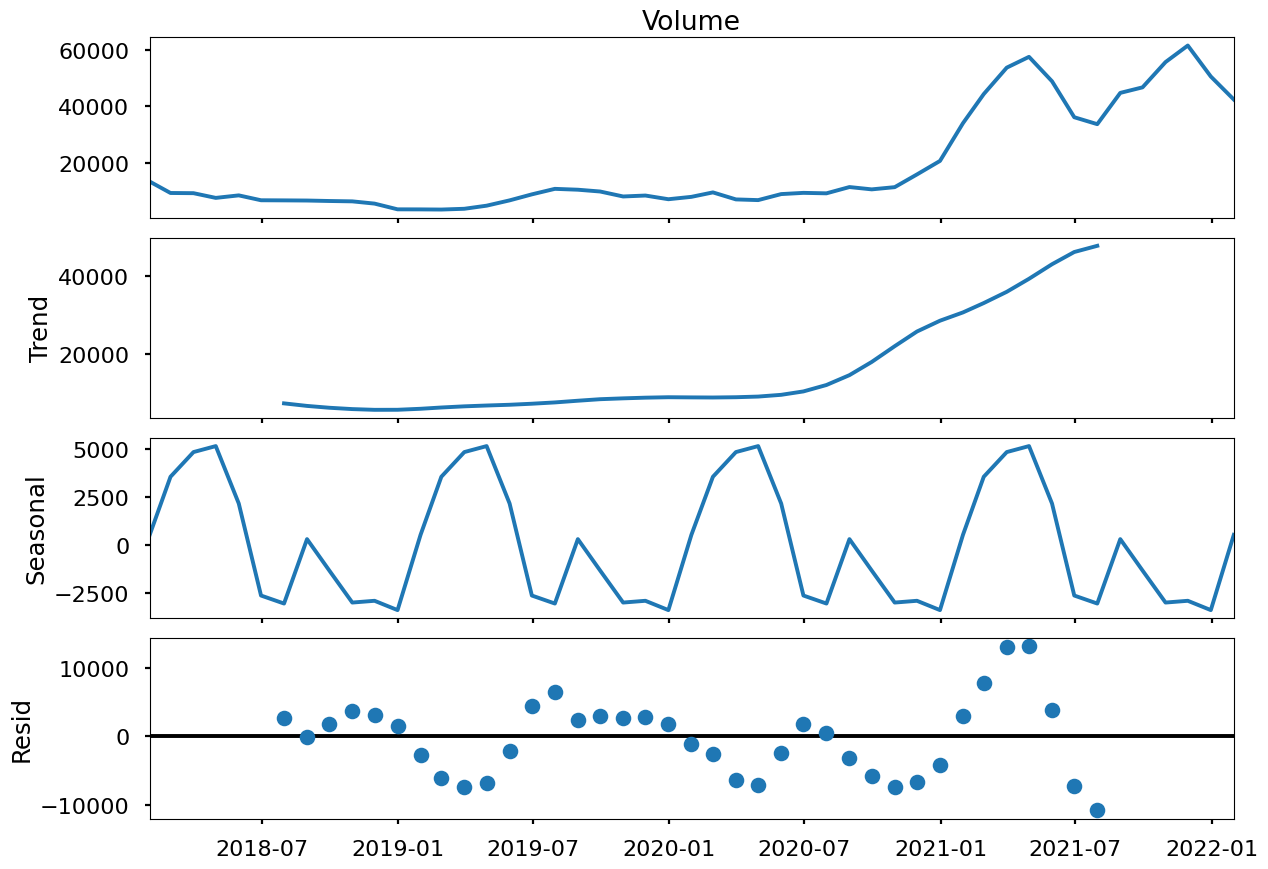

In [124]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Volume).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Volume)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [127]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Volume)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Volume)[1])

Dickey–Fuller test: p=0.986021


The series are not stationary.

## Seasonal differentiation

In [128]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.065423


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.022673


<Figure size 1500x700 with 0 Axes>

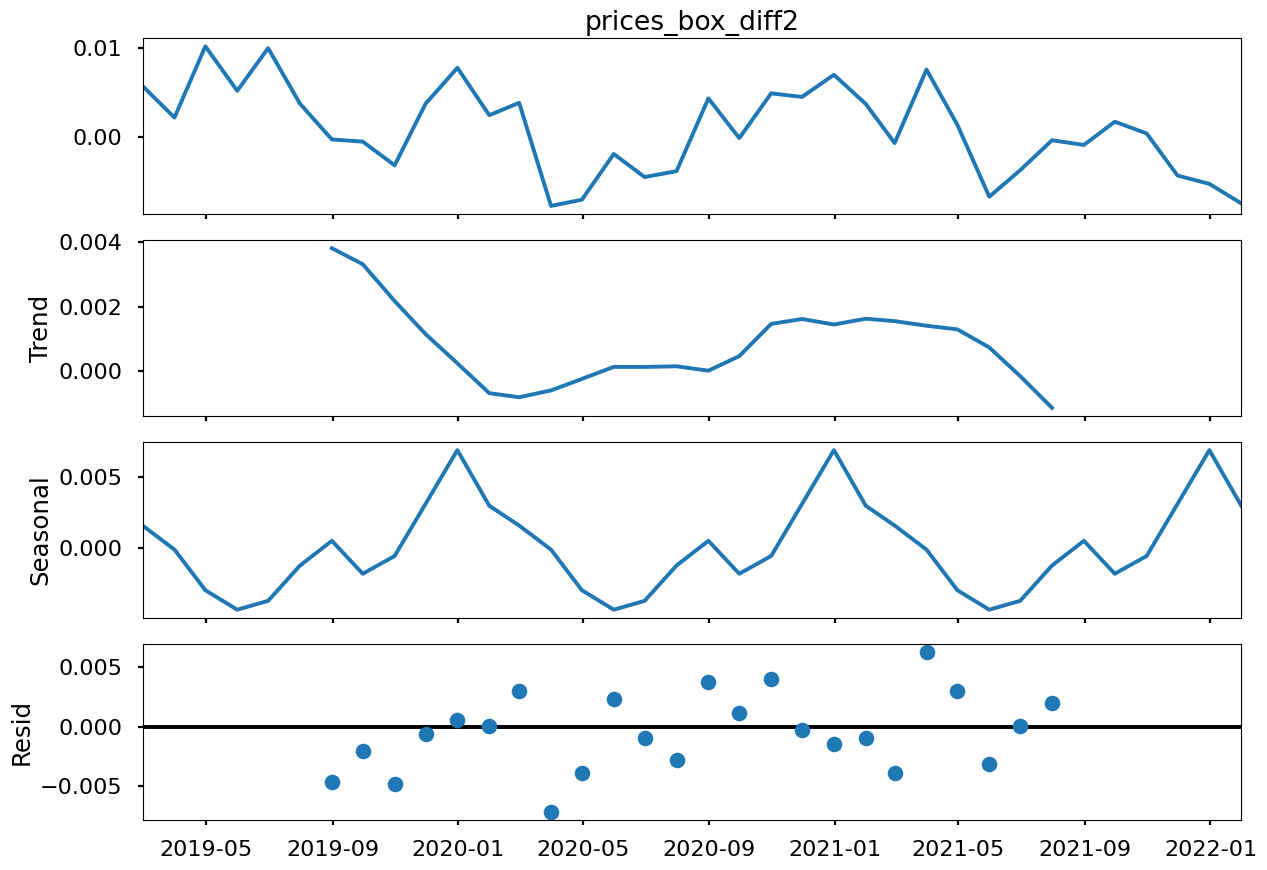

In [129]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

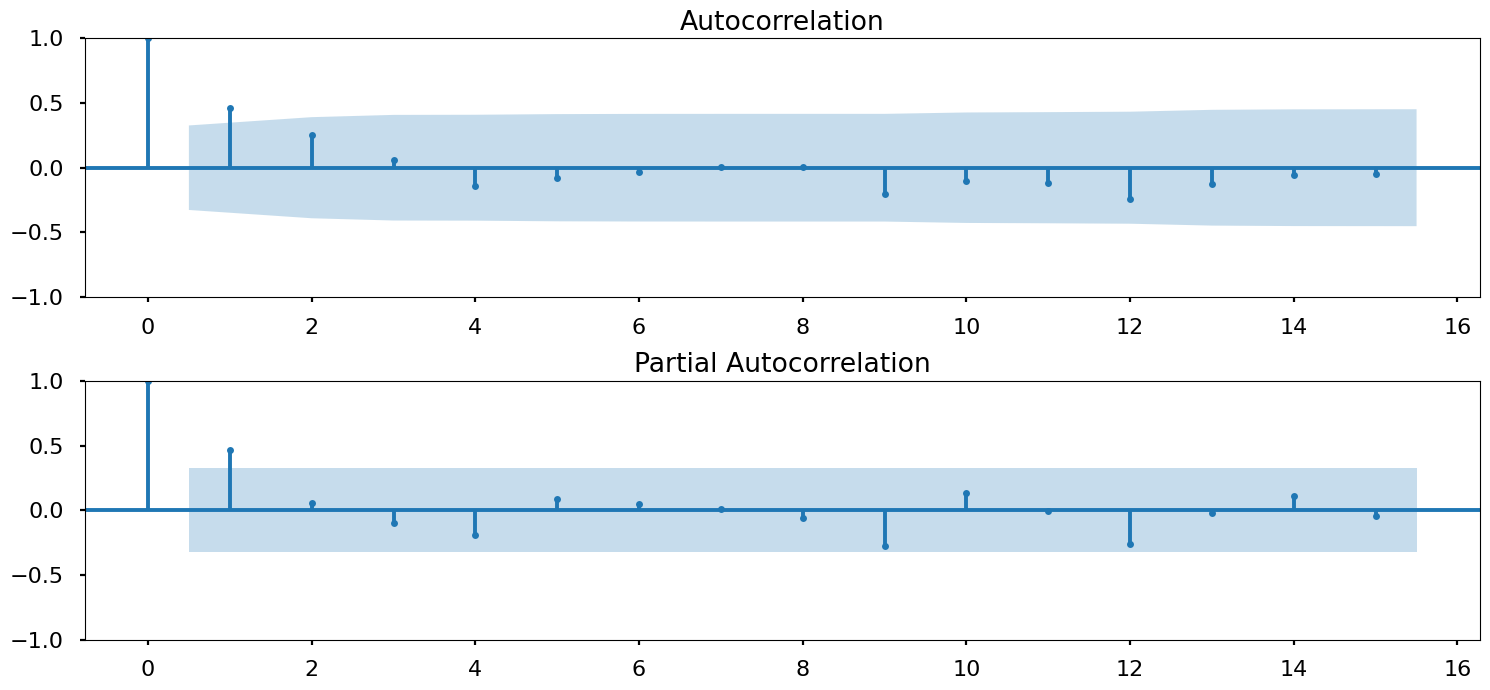

In [145]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=15, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=15, ax=ax)
plt.tight_layout()
plt.show()

In [146]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [147]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
22  (1, 0, 2, 0) -287.437071
20  (1, 0, 1, 0) -286.688422
18  (1, 0, 0, 0) -286.014811
40  (2, 0, 2, 0) -285.939503
28  (1, 1, 2, 0) -285.529212
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                   49
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 147.719
Date:                            Wed, 10 Jan 2024   AIC                           -287.437
Time:                                    19:47:22   BIC                           -281.103
Sample:                                01-31-2018   HQIC                          -285.226
                                     - 01-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

## Analysis of residues

Dickey–Fuller test:: p=0.000000


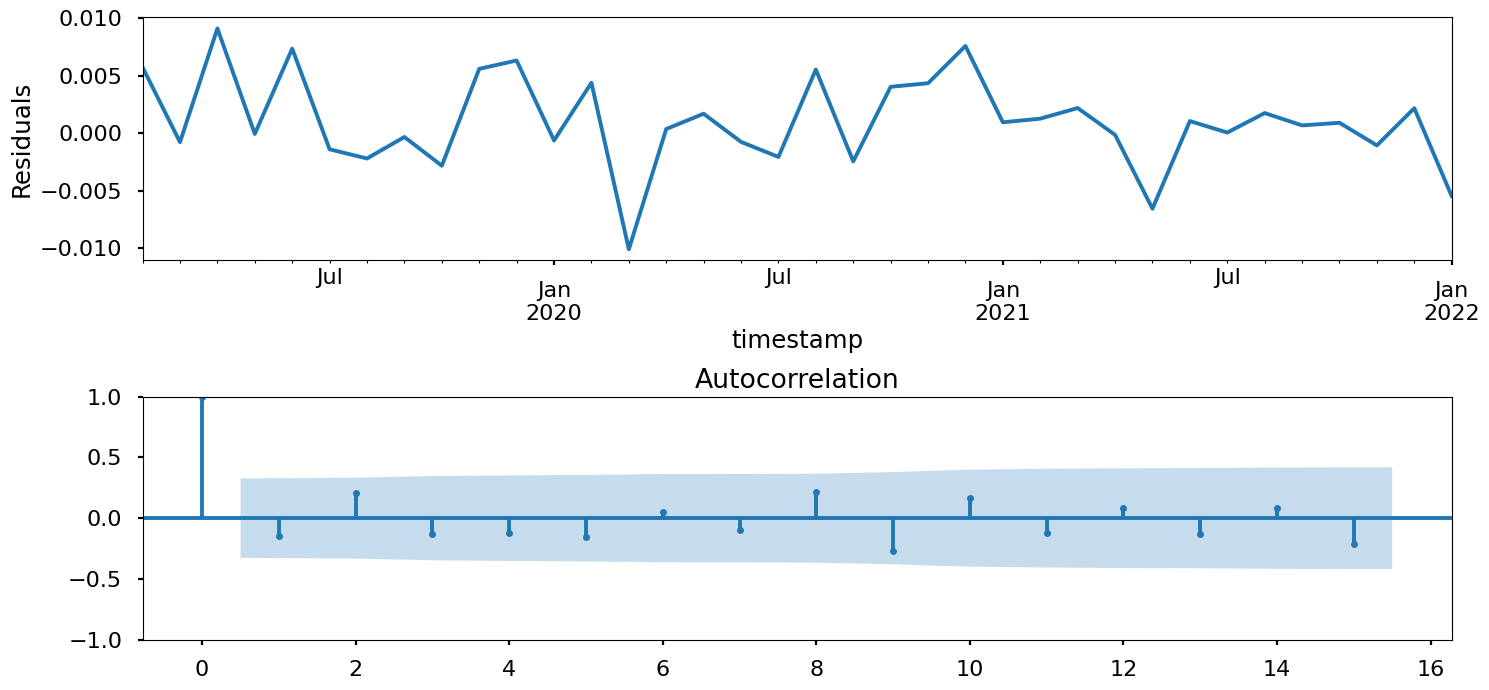

In [148]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=15, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It`s OK.

## Prediction

In [149]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

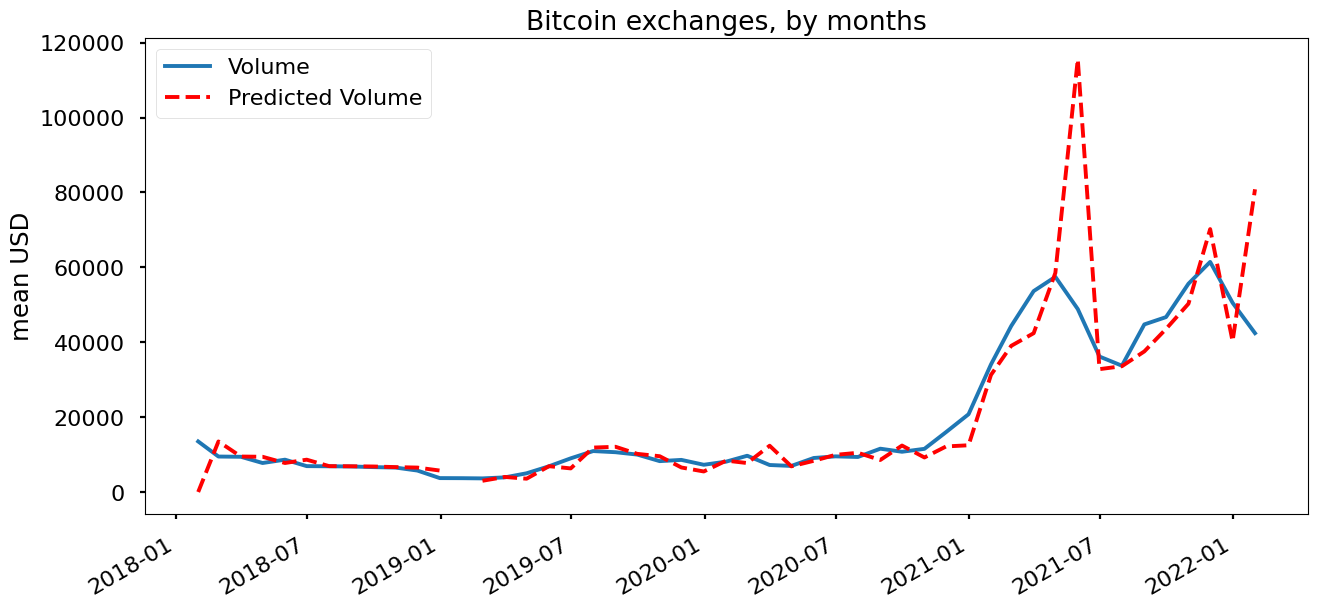

In [152]:
# Prediction
df_month2 = df_month[['Volume']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Volume.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Volume')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()